## Metodo de K-Means para clasificar articulos de acuerdo a sus ventas
Se importan las bibliotecas necesarias

In [2]:
#import cx_Oracle as oc
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn import preprocessing
import matplotlib.pyplot as plt

Se crea la conexion a la base de datos y se crea el dataset de una familia de articulos con la suma de ventas, ejemplo
 * DIV_CVE_N =1 -- 1	CALZADO
 * SEC_CVE_N=5 -- 5	DAMA
 * sbc_cve_n=66 -- 66	CHOCLO
 * cat_cve_n=17 -- 17	CONFORT

In [ ]:
con=oc.connect('SYSTEM/admin@localhost')

sql=pd.read_sql_query('''
 SELECT
    v.ult_sust_def_n art,v.talla_ini_min,v.talla_fin_max,
    SUM(venta) vta
FROM
    ventas   v,
    segmentacion   s
WHERE
    v.ult_sust_def_n = s.ult_sust_def
    AND v.talla_ini_min = s.talla_ini_min
    AND v.talla_fin_max = s.talla_fin_max
    AND s.DIV_CVE_N =1 -- 1	CALZADO
    and s.SEC_CVE_N=5 -- 5	DAMA
    and s.sbc_cve_n=66 -- 66	CHOCLO
    and s.cat_cve_n=17 -- 17	CONFORT
GROUP BY
    v.ult_sust_def_n,v.talla_ini_min,v.talla_fin_max   
''',con)


In [ ]:
df=pd.DataFrame(sql)
df.head(5)

,ART,TALLA_INI_MIN,TALLA_FIN_MAX,VTA
0,96723,22.0,27.0,886
1,142678,22.0,27.0,502
2,142684,22.0,27.0,728
3,153930,22.0,27.0,880
4,154187,22.0,27.0,814


In [3]:
lst1=[908839,154201,166340,908834,823456,166338,823454,831878]
lst2=[4359,2769,2547,4736,3489,2207,1551,2461]
df = pd.DataFrame(list(zip(lst1, lst2)),
               columns =['ART', 'VTA'])

Se normaliza la clave del articulo para que no influya en la creacion de los grupos

In [4]:
x = df['ART'].values.reshape(-1, 1) #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df['art_norm'] = pd.DataFrame(x_scaled)

In [5]:
df

,ART,VTA,art_norm
0,908839,4359,1.000000
1,154201,2769,0.000000
2,166340,2547,0.016086
3,908834,4736,0.999993
4,823456,3489,0.886856
5,166338,2207,0.016083
6,823454,1551,0.886853
7,831878,2461,0.898016


Se grafica la informacion sin agrupar

In [7]:
X=df[['art_norm','VTA']].to_numpy()

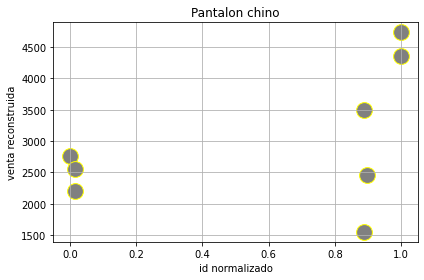

In [11]:
plt.scatter(X[:,0],
           X[:,1],
           c='gray',
           marker='o',
           edgecolor='yellow',
           s=250)
plt.grid()
plt.title('Pantalon chino')
plt.xlabel('id normalizado')
plt.ylabel('venta reconstruida')
plt.tight_layout()

Se aplica el metodo del codo para identificar el numero de grupos que se requieren

In [13]:
distorcions=[]
for i in range(1,6):
    km=KMeans(n_clusters=i,
             init='k-means++',
             n_init=10,
             max_iter=300,
             random_state=0)
    km.fit(X)
    distorcions.append(km.inertia_)

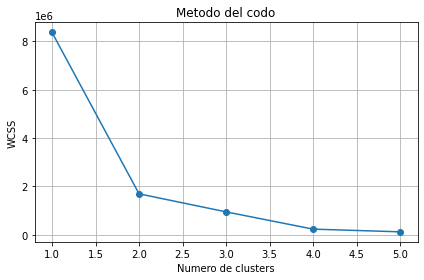

In [14]:
plt.plot(range(1,6),distorcions,marker='o')
plt.title('Metodo del codo')
plt.xlabel('Numero de clusters')
plt.ylabel('WCSS')
plt.tight_layout()
plt.grid()
plt.show()

Se identifica que el numero de grupos debe ser 3 porque a mayor numero de grupos las distorciones ya no se mejoran. La variable y_km guarda las clasificaciones.

In [32]:
km=KMeans(n_clusters=3,
         init='k-means++',
         n_init=10,
         max_iter=300,
         tol=1e-4,
         random_state=0)
y_km=km.fit_predict(X)

In [34]:
print(sorted(km.cluster_centers_[:,1],reverse=True))


[4547.5, 3489.0, 2307.0]


Se grafican los grupos

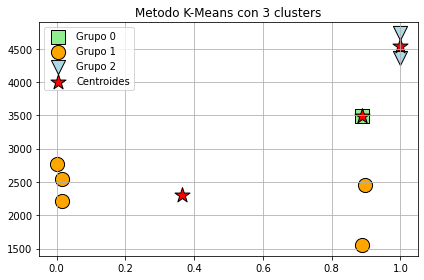

In [35]:
plt.scatter(X[y_km==0,0],
           X[y_km==0,1],
           s=200,marker='s',
           c='lightgreen',edgecolor='black',
           label='Grupo 0')

plt.scatter(X[y_km==1,0],
           X[y_km==1,1],
           s=200,marker='o',
           c='orange',edgecolor='black',
           label='Grupo 1')

plt.scatter(X[y_km==2,0],
           X[y_km==2,1],
           s=200,marker='v',
           c='lightblue',edgecolor='black',
           label='Grupo 2')

plt.scatter(km.cluster_centers_[:,0],
           km.cluster_centers_[:,1],
           s=250,marker='*',
           c='red',edgecolor='black',
           label='Centroides')

plt.legend(scatterpoints=1)
plt.title('Metodo K-Means con 3 clusters')
plt.grid()
plt.tight_layout()
plt.show()

Actualiza el grupo

In [19]:
df['Grupo'] = pd.DataFrame(y_km)

In [20]:
df['Grupo'].value_counts()

1    5
2    2
0    1
Name: Grupo, dtype: int64

Actualiza el grupo en la base de datos **se debe actualizar la clasificación porque no siempre genera el mismo número de grupo**

In [35]:
def getGrupo(i):
    switcher={
        0:'Riesgo',
        2:'Regular',
        1:'Bueno'
    }
    return switcher.get(i,"??")

In [ ]:
upd = ''' UPDATE segmentacion
             SET CLASIFICACION = :grupo 
           WHERE ult_sust_def = :id
             AND talla_ini_min = :talla_ini
             AND talla_fin_max = :talla_fin '''
for index,reg in df.iterrows():
    g=reg['Grupo']
    grupo=getGrupo(g)
    id=reg['ART']
    talla_ini=reg['TALLA_INI_MIN']
    talla_fin=reg['TALLA_FIN_MAX']
    cur = con.cursor()
    cur.execute(upd,[grupo,id,talla_ini,talla_fin])
    con.commit()

cierra el cursor y la conexion

In [ ]:
cur.close()
del cur
con.close()